# Propeller comparison analysis (optimization_unified)


In [ ]:
import os
from functools import lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct

import sys

sys.path.append("../../../")
sys.path.append("../propeller")

from utils.plot import config_matplotlib, figsize, fig_save_and_show
from utils.optimization import load_model_params_from_json
from model import SolarBoatFull

from helper import (
    _estimate_bseries_poly_coeffs,
    _estimate_prop_chord_07,
    _estimate_prop_I_r,
)

config_matplotlib()
latex_img_path = "/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/"
latex_tex_path = "/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/"

## Data


In [ ]:
DATA_DIR = "data"
CSV_ENDURANCE = os.path.join(DATA_DIR, "optimization_unified_endurance.csv")
CSV_SPRINT = os.path.join(DATA_DIR, "optimization_unified_sprint.csv")
CSV_PARETO = os.path.join(DATA_DIR, "optimization_unified_pareto.csv")

M_TO_INCH = 39.3701
MPS_TO_KMH = 3.6
RADPS_TO_RPM = 30.0 / np.pi

PV_G_SCENARIOS = [200.0, 400.0, 600.0, 800.0]  # W/m²
PV_G_WEIGHTS = np.array([0.15, 0.35, 0.35, 0.15], dtype=float)
PV_G_WEIGHTS = PV_G_WEIGHTS / PV_G_WEIGHTS.sum()
PV_G_MEAN = float(np.sum(np.array(PV_G_SCENARIOS, dtype=float) * PV_G_WEIGHTS))

BATT_Z_INITIAL = 1.0
BATT_V_INITIAL = 36.0
TRANSIENT_SKIP = 10

solar_boat_params = load_model_params_from_json("solar_boat_params.json")

df_endurance = pd.read_csv(CSV_ENDURANCE)
df_sprint = pd.read_csv(CSV_SPRINT)
df_pareto = pd.read_csv(CSV_PARETO)

display(df_endurance.head())
display(df_sprint.head())
display(df_pareto.head())

,Unnamed: 0,Caso,trans_k,esc_d [%],prop_D [in],prop_P [in],hull_u [km/h],Distância [km],batt_z final [%],motor_q max [Nm],motor_w [rad/s],prop_j [-],prop_w [rad/s],vs Baseline [%]
0,0,Baseline,0.636364,40.011824,9.000005,10.500006,8.488870,42.444352,63.855611,3.735796,136.47412,0.677138,86.847167,0.000000
1,1,Caso 1,0.477286,52.844427,9.000005,10.500006,8.556891,42.784453,63.647149,2.850359,183.41807,0.677139,87.542825,0.801286


,Unnamed: 0,Caso,trans_k,esc_d [%],prop_D [in],prop_P [in],hull_u [km/h],Distância [km],batt_z final [%],motor_q max [Nm],motor_w [rad/s],prop_j [-],prop_w [rad/s],vs Baseline [%]
0,0,Baseline,0.636364,100.0,9.000005,10.500006,18.000000,0.24,96.144771,15.319955,297.267559,0.677240,189.170265,0.000000
1,1,Caso 1,0.925004,100.0,9.000005,10.500006,20.571429,0.24,93.266279,28.953964,232.524026,0.677346,215.085655,14.285714


,Unnamed: 0,trans_k,esc_d_sprint [%],esc_d_endurance [%],prop_D_sprint [in],prop_PD_sprint,prop_P_sprint [in],prop_D_endurance [in],prop_PD_endurance,prop_P_endurance [in],sprint_speed [m/s],sprint_speed [km/h],endurance_distance [km],vs Baseline Sprint [%],vs Baseline Endurance [%]
0,0,0.506632,100.0,43.967219,11.810327,1.599406,18.889503,10.903394,0.907646,9.896425,6.000000,21.600000,43.926865,20.000000,3.492839
1,1,0.506632,100.0,43.967219,11.807309,1.598569,18.874797,10.903394,0.907646,9.896425,6.000000,21.600000,43.926865,20.000000,3.492839
2,2,0.506632,100.0,43.967219,11.808931,1.598569,18.877389,10.903394,0.907646,9.896425,6.000000,21.600000,43.926865,20.000000,3.492839
3,3,0.480015,100.0,43.966614,11.659821,1.597358,18.624909,11.219655,0.924667,10.374449,5.853659,21.073171,44.062406,17.073171,3.812178
4,4,0.480015,100.0,43.966614,11.683430,1.576142,18.414746,11.219655,0.924667,10.374449,5.853659,21.073171,44.062406,17.073171,3.812178


## Helpers


In [ ]:
# Propeller constants (copied from optimization_unified.ipynb)
PROP_Z = 3
PROP_AEA0 = 0.242
PROP_HUB_D = 0.06
PROP_BLADE_THICKNESS = 0.005
PROP_MAT_RHO = 2700.0
PROP_TOTAL_M = 0.66


def create_propeller_params(prop_D: float, prop_PD: float, Rn: float = 2e6) -> dict:
    prop_k_T_coeffs, prop_k_Q_coeffs = _estimate_bseries_poly_coeffs(
        prop_PD=prop_PD,
        prop_AEA0=PROP_AEA0,
        prop_Z=PROP_Z,
        Rn=Rn,
    )

    geom = _estimate_prop_chord_07(
        prop_D=prop_D,
        prop_hub_D=PROP_HUB_D,
        prop_AEA0=PROP_AEA0,
        prop_Z=PROP_Z,
    )

    inertia = _estimate_prop_I_r(
        prop_blade_thickness=PROP_BLADE_THICKNESS,
        prop_mat_rho=PROP_MAT_RHO,
        prop_AE=geom["prop_AE"],
        prop_Z=PROP_Z,
        prop_hub_R=geom["prop_hub_R"],
        prop_L_radial=geom["prop_L_radial"],
        prop_total_m=PROP_TOTAL_M,
    )
    prop_I_r = inertia["J_total"] if inertia is not None else 0.0006

    return {
        "prop_D": float(prop_D),
        "prop_PD": float(prop_PD),
        "prop_P": float(prop_PD) * float(prop_D),
        "prop_k_T_coeffs": prop_k_T_coeffs,
        "prop_k_Q_coeffs": prop_k_Q_coeffs,
        "prop_I_r": float(prop_I_r),
    }


def build_params_with_propeller(
    base_params: dict, trans_k: float, prop_params: dict
) -> dict:
    p = base_params.copy()
    p["trans_k"] = float(trans_k)
    p["prop_D"] = float(prop_params["prop_D"])
    p["prop_k_T_coeffs"] = prop_params["prop_k_T_coeffs"]
    p["prop_k_Q_coeffs"] = prop_params["prop_k_Q_coeffs"]
    p["prop_I_r"] = float(prop_params["prop_I_r"])
    return p


def compute_wh_per_km(df: pd.DataFrame) -> pd.Series:
    return (df["esc_p_in"] / df["hull_u"]) * (1000.0 / 3600.0)


def compute_propulsive_eta(df: pd.DataFrame) -> pd.Series:
    cols = ["esc_eta", "motor_eta", "trans_eta", "prop_eta", "hull_eta"]
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns for propulsive_eta: {missing}")
    return (
        df["esc_eta"]
        * df["motor_eta"]
        * df["trans_eta"]
        * df["prop_eta"]
        * df["hull_eta"]
    ).clip(lower=0.0)


def simulate_constant_point(
    sim_params: dict,
    esc_d: float,
    pv_g: float,
    sim_time_s: float = 600.0,
    dt: float = 1.0,
) -> pd.DataFrame:
    sys = SolarBoatFull.build(sim_params)
    T = np.arange(0.0, float(sim_time_s) + float(dt), float(dt))
    U = np.array([[float(pv_g)] * len(T), [float(esc_d)] * len(T)])
    X0 = SolarBoatFull.initial_state(
        X0={"batt_z": BATT_Z_INITIAL, "batt_v": BATT_V_INITIAL},
        U0=U[:, 0],
        params=sim_params,
    )
    res = ct.input_output_response(sys, T=T, U=U, X0=X0, solve_ivp_method="Radau")
    df = res.to_pandas()
    df["Wh_per_km"] = compute_wh_per_km(df).replace([np.inf, -np.inf], np.nan)
    df["propulsive_eta"] = compute_propulsive_eta(df)
    return df


@lru_cache(maxsize=2048)
def evaluate_endurance_point_cached(
    trans_k: float,
    esc_d_pct: float,
    prop_D_in: float,
    prop_PD: float,
    pv_g: float = PV_G_MEAN,
) -> dict:
    trans_k = float(trans_k)
    esc_d = float(esc_d_pct) / 100.0
    prop_D_m = float(prop_D_in) / M_TO_INCH
    prop_params = create_propeller_params(prop_D=prop_D_m, prop_PD=float(prop_PD))
    sim_params = build_params_with_propeller(
        solar_boat_params, trans_k=trans_k, prop_params=prop_params
    )

    df = simulate_constant_point(
        sim_params, esc_d=esc_d, pv_g=float(pv_g), sim_time_s=600.0, dt=1.0
    )
    start_idx = min(int(TRANSIENT_SKIP), len(df) - 1)
    df_valid = df.iloc[start_idx:].copy()
    df_valid = df_valid[
        (df_valid["hull_u"] > 0.2) & (df_valid["esc_p_in"] > 1.0)
    ].copy()

    return {
        "df": df,
        "wh_per_km_mean": (
            float(df_valid["Wh_per_km"].mean()) if len(df_valid) else float("nan")
        ),
        "propulsive_eta_mean": (
            float(df_valid["propulsive_eta"].mean()) if len(df_valid) else float("nan")
        ),
        "motor_q_load_max": (
            float(df_valid["motor_q_load"].max())
            if (len(df_valid) and "motor_q_load" in df_valid.columns)
            else float("nan")
        ),
        "prop_w_rpm_mean": (
            float(df_valid["prop_w"].mean() * RADPS_TO_RPM)
            if (len(df_valid) and "prop_w" in df_valid.columns)
            else float("nan")
        ),
        "hull_u_kmh_mean": (
            float(df_valid["hull_u"].mean() * MPS_TO_KMH)
            if len(df_valid)
            else float("nan")
        ),
    }

## Candidates and metrics


In [ ]:
# Build candidate set from Pareto (endurance propeller)
df_candidates = df_pareto.copy()
df_candidates["solution_id"] = df_candidates.index.astype(int)
df_candidates = df_candidates.rename(
    columns={
        "esc_d_endurance [%]": "esc_d_endurance_pct",
        "prop_D_endurance [in]": "prop_D_endurance_in",
        "prop_PD_endurance": "prop_PD_endurance",
        "prop_P_endurance [in]": "prop_P_endurance_in",
        "sprint_speed [km/h]": "max_speed_kmh",
        "endurance_distance [km]": "endurance_distance_km",
    }
)

rows = []
for _, r in df_candidates.iterrows():
    m = evaluate_endurance_point_cached(
        float(r["trans_k"]),
        float(r["esc_d_endurance_pct"]),
        float(r["prop_D_endurance_in"]),
        float(r["prop_PD_endurance"]),
        PV_G_MEAN,
    )
    rows.append(
        {
            "solution_id": int(r["solution_id"]),
            "name": f"pareto_{int(r['solution_id'])}",
            "trans_k": float(r["trans_k"]),
            "esc_d_endurance_pct": float(r["esc_d_endurance_pct"]),
            "prop_D_in": float(r["prop_D_endurance_in"]),
            "prop_P_in": float(r["prop_P_endurance_in"]),
            "prop_PD": float(r["prop_PD_endurance"]),
            "max_speed_kmh": float(r["max_speed_kmh"]),
            "endurance_distance_km": float(r["endurance_distance_km"]),
            "Wh_per_km": float(m["wh_per_km_mean"]),
            "propulsive_eta": float(m["propulsive_eta_mean"]),
            "motor_q_load_max": float(m["motor_q_load_max"]),
            "prop_w_rpm": float(m["prop_w_rpm_mean"]),
            "hull_u_end_kmh": float(m["hull_u_kmh_mean"]),
        }
    )

# Add current setup from Baseline rows
row_end_base = df_endurance[df_endurance["Caso"] == "Baseline"].iloc[0]
row_sprint_base = df_sprint[df_sprint["Caso"] == "Baseline"].iloc[0]
current_trans_k = float(row_end_base["trans_k"])
current_esc_d_end_pct = float(row_end_base["esc_d [%]"])
current_prop_D_in = float(row_end_base["prop_D [in]"])
current_prop_P_in = float(row_end_base["prop_P [in]"])
current_prop_PD = current_prop_P_in / max(current_prop_D_in, 1e-9)
current_max_speed_kmh = float(row_sprint_base["hull_u [km/h]"])
current_endurance_km = float(row_end_base["Distância [km]"])

m_cur = evaluate_endurance_point_cached(
    current_trans_k,
    current_esc_d_end_pct,
    current_prop_D_in,
    current_prop_PD,
    PV_G_MEAN,
)
rows.append(
    {
        "solution_id": -1,
        "name": "current",
        "trans_k": current_trans_k,
        "esc_d_endurance_pct": current_esc_d_end_pct,
        "prop_D_in": current_prop_D_in,
        "prop_P_in": current_prop_P_in,
        "prop_PD": current_prop_PD,
        "max_speed_kmh": current_max_speed_kmh,
        "endurance_distance_km": current_endurance_km,
        "Wh_per_km": float(m_cur["wh_per_km_mean"]),
        "propulsive_eta": float(m_cur["propulsive_eta_mean"]),
        "motor_q_load_max": float(m_cur["motor_q_load_max"]),
        "prop_w_rpm": float(m_cur["prop_w_rpm_mean"]),
        "hull_u_end_kmh": float(m_cur["hull_u_kmh_mean"]),
    }
)

df_metrics = pd.DataFrame(rows)
display(df_metrics.sort_values("Wh_per_km").head(10))

,solution_id,name,trans_k,esc_d_endurance_pct,prop_D_in,prop_P_in,prop_PD,max_speed_kmh,endurance_distance_km,Wh_per_km,propulsive_eta,motor_q_load_max,prop_w_rpm,hull_u_end_kmh
61,61,pareto_61,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
73,73,pareto_73,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
72,72,pareto_72,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
71,71,pareto_71,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
70,70,pareto_70,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
69,69,pareto_69,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
68,68,pareto_68,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
67,67,pareto_67,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
66,66,pareto_66,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752
65,65,pareto_65,0.480015,43.966614,11.219655,10.374449,0.924667,21.073171,44.062406,62.849325,0.558833,3.091848,709.164739,9.029752


## Decision plot


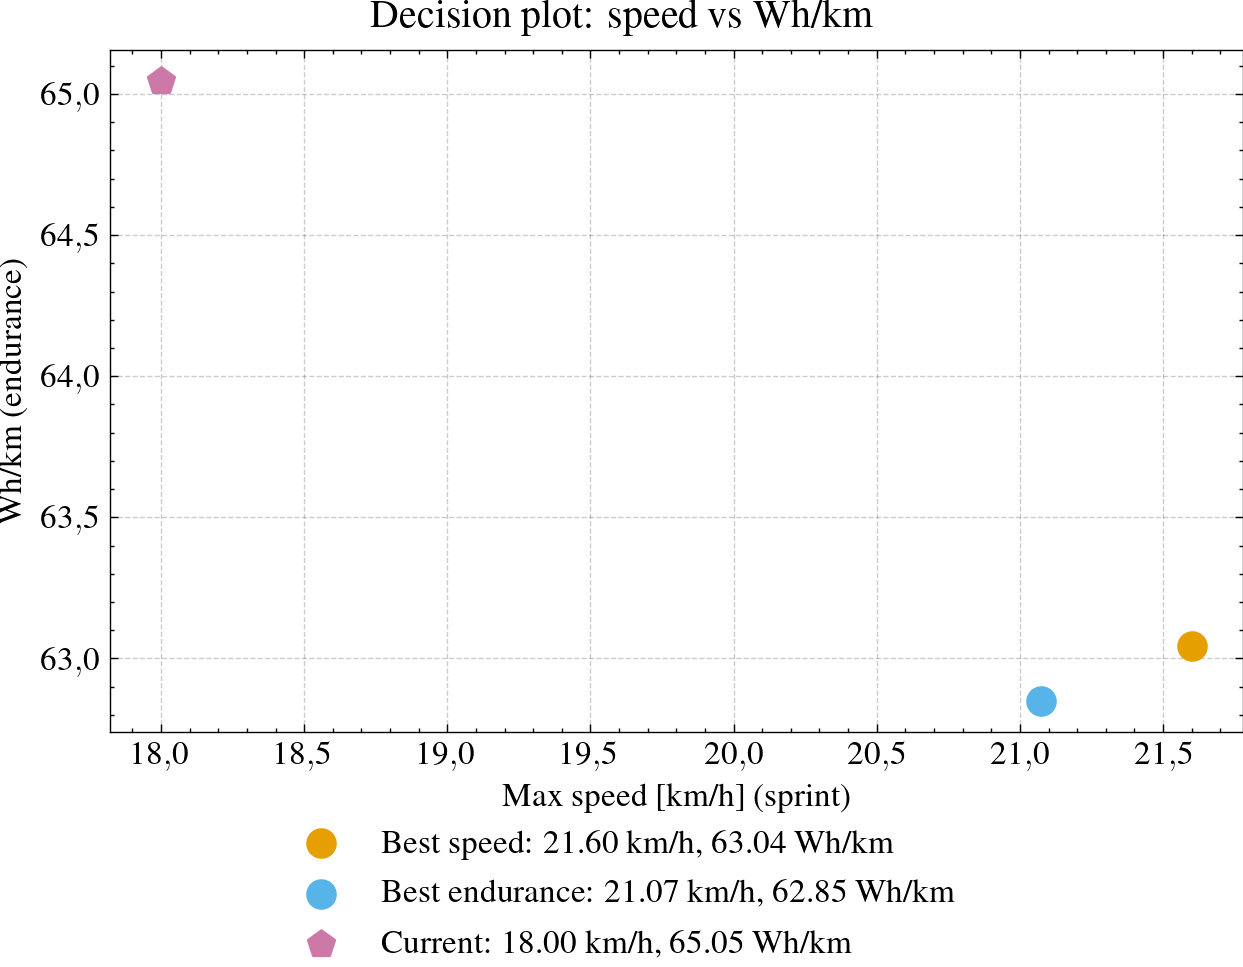

In [ ]:
# Data prep
df_p = df_metrics[df_metrics["solution_id"] >= 0].copy()
df_c = df_metrics[df_metrics["solution_id"] == -1].copy()
current_row = df_c.iloc[0] if len(df_c) else None

# Unique Pareto points in objective space
df_u = df_p.drop_duplicates(subset=["max_speed_kmh", "Wh_per_km"]).reset_index(
    drop=True
)

# If there are more than 2 unique Pareto points for some reason, keep the two extremes
if len(df_u) > 2:
    i_best_wh = df_u["Wh_per_km"].idxmin()
    i_best_sp = df_u["max_speed_kmh"].idxmax()
    df_u = df_u.loc[[i_best_wh, i_best_sp]].reset_index(drop=True)

i_best_wh = df_u["Wh_per_km"].idxmin()
i_best_sp = df_u["max_speed_kmh"].idxmax()

points = []

for i, r in df_u.iterrows():
    if i == i_best_wh:
        name = "Best endurance"
    elif i == i_best_sp:
        name = "Best speed"
    else:
        name = f"Pareto {i+1}"

    points.append(
        {
            "name": name,
            "x": float(r["max_speed_kmh"]),
            "y": float(r["Wh_per_km"]),
        }
    )

if current_row is not None:
    points.append(
        {
            "name": "Current",
            "x": float(current_row["max_speed_kmh"]),
            "y": float(current_row["Wh_per_km"]),
        }
    )
# Plot
fig, ax = plt.subplots(figsize=figsize(), layout="constrained")

markers = ["o", "o", "p"]
for k, p in enumerate(points):
    marker = markers[k] if k < len(markers) else "o"
    label = f"{p['name']}: {p['x']:.2f} km/h, {p['y']:.2f} Wh/km"
    ax.scatter(p["x"], p["y"], s=100, marker=marker, color=f"C{k}", label=label)

ax.set_xlabel("Max speed [km/h] (sprint)")
ax.set_ylabel("Wh/km (endurance)")
ax.grid(True, alpha=0.2)

fig_save_and_show(
    filename=f"{latex_img_path}/propeller_comparison_analysis_decision_plot.pdf",
    show_title="Decision plot: speed vs Wh/km",
    save_title="Comparação das soluções: velocidade máxima vs consumo (Wh/km)",
    ncol=1,
    fig=fig,
    ax=ax,
)

## Summary table


In [ ]:
# Summary table: current vs bests
rows = []
if current_row is not None:
    rows.append(("Current", current_row))
rows.append(("Best Wh/km", best_wh_row))
rows.append(("Best max speed", best_speed_row))

cols = [
    "trans_k",
    "esc_d_endurance_pct",
    "prop_D_in",
    "prop_P_in",
    "prop_PD",
    "Wh_per_km",
    "propulsive_eta",
    "motor_q_load_max",
    "prop_w_rpm",
    "hull_u_end_kmh",
    "max_speed_kmh",
    "endurance_distance_km",
]
df_summary = pd.DataFrame(
    [
        {
            "-": name,
            **{c: float(r[c]) for c in cols},
        }
        for name, r in rows
    ]
).set_index("-")

df_summary = df_summary.rename(
    columns={
        "trans_k": "trans_k [-]",
        "esc_d_endurance_pct": "esc_d_endurance [%]",
        "prop_D_in": "prop_D [in]",
        "prop_P_in": "prop_P [in]",
        "prop_PD": "P/D [-]",
        "Wh_per_km": "Wh/km",
        "propulsive_eta": "propulsive_eta [-]",
        "motor_q_load_max": "motor_q_load_max [Nm]",
        "prop_w_rpm": "prop_w [RPM]",
        "hull_u_end_kmh": "endurance hull_u [km/h]",
        "max_speed_kmh": "max speed [km/h]",
        "endurance_distance_km": "endurance distance [km]",
    }
).T
display(df_summary.round(4))

summary_table_latex = df_summary.to_latex(
    index=True,
    caption="Resumo comparativo das opções de hélice/transmissão",
    label="table:propeller_comparison_summary_table",
    float_format="%.2f",
    column_format="l" + "|c" * len(df_summary.columns),
    escape=True,
    decimal=",",
    position="H",
    multicolumn=True,
)
summary_table_latex = (
    summary_table_latex.replace("\\toprule", "\\hline")
    .replace("\\bottomrule\n", "")
    .replace("\\midrule", "\\hline")
    .replace("\\end{table}", "\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}")
    .replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
)
with open(
    f"{latex_tex_path}/propeller_comparison_analysis_summary_table.tex", "w"
) as f:
    f.write(summary_table_latex)

-,Current,Best Wh/km,Best max speed
trans_k [-],0.6364,0.4800,0.5066
esc_d_endurance [%],40.0118,43.9666,43.9672
prop_D [in],9.0000,11.2197,10.9034
prop_P [in],10.5000,10.3744,9.8964
P/D [-],1.1667,0.9247,0.9076
Wh/km,65.0456,62.8493,63.0434
propulsive_eta [-],0.5009,0.5588,0.5537
motor_q_load_max [Nm],3.3789,3.0918,3.0919
prop_w [RPM],849.6029,709.1647,748.4993
endurance hull_u [km/h],8.6969,9.0298,9.0020


## Hull performance


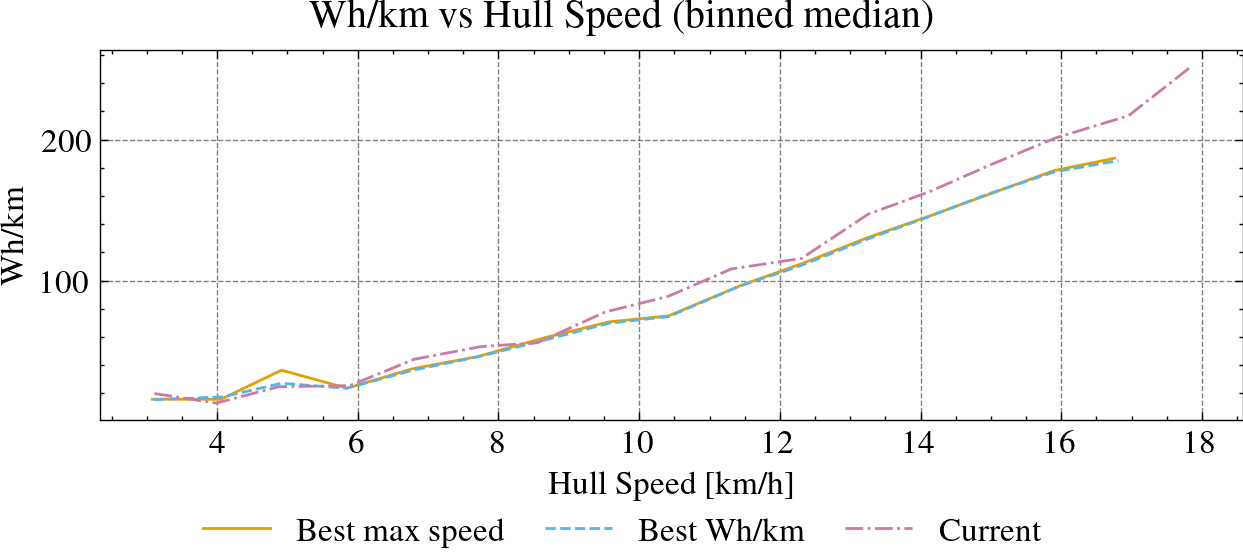

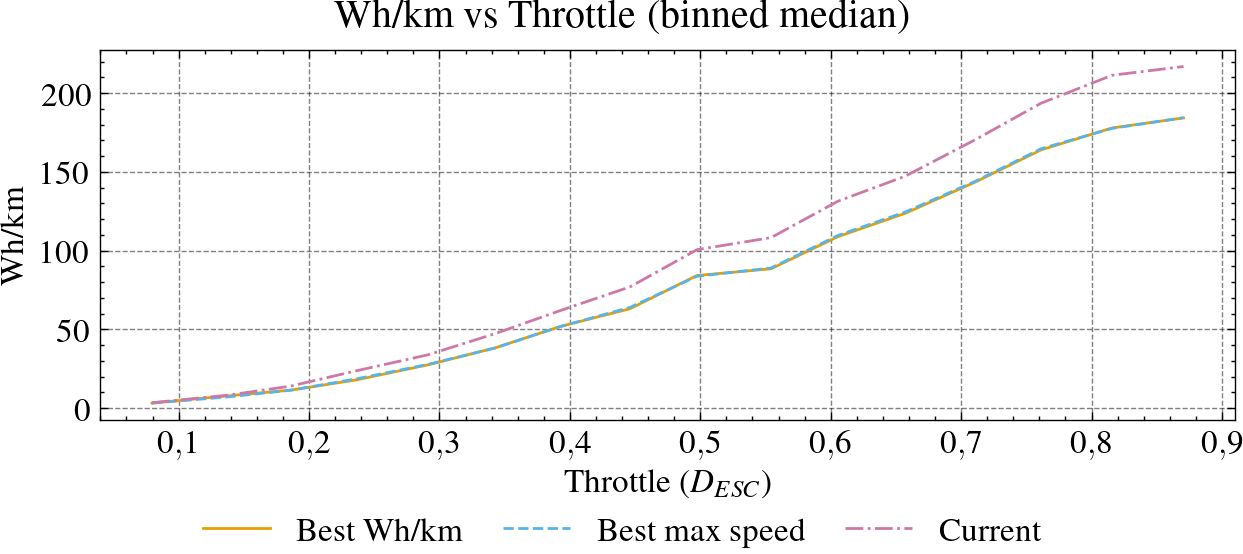

In [ ]:
def simulate_throttle_sweep(
    sim_params: dict,
    pv_g: float = PV_G_MEAN,
    duration_s: float = 600.0,
    dt: float = 1.0,
) -> pd.DataFrame:
    sys = SolarBoatFull.build(sim_params)
    dt = float(dt)
    T = np.arange(0.0, float(duration_s) + dt, dt)

    # Rich excitation in [0,1]: multi-cycle triangle + multi-sine
    cycles = 6.0
    phase = np.linspace(0.0, cycles, len(T))
    tri = 1.0 - np.abs(2.0 * (phase % 1.0) - 1.0)
    osc = (
        0.22 * np.sin(2.0 * np.pi * phase * 1.7)
        + 0.14 * np.sin(2.0 * np.pi * phase * 7.3)
        + 0.08 * np.sin(2.0 * np.pi * phase * 17.0)
    )
    esc_d_raw = tri + osc
    esc_d_raw = (esc_d_raw - np.min(esc_d_raw)) / (
        np.max(esc_d_raw) - np.min(esc_d_raw) + 1e-12
    )
    esc_d = np.clip(esc_d_raw, 0.0, 1.0)

    U = np.array([[float(pv_g)] * len(T), esc_d])
    X0 = SolarBoatFull.initial_state(
        X0={"batt_z": BATT_Z_INITIAL, "batt_v": BATT_V_INITIAL},
        U0=U[:, 0],
        params=sim_params,
    )
    res = ct.input_output_response(sys, T=T, U=U, X0=X0, solve_ivp_method="Radau")
    df = res.to_pandas().set_index("time").copy()
    df["esc_d"] = esc_d
    df["Wh_per_km"] = compute_wh_per_km(df).replace([np.inf, -np.inf], np.nan)
    return df


def simulate_throttle_sweep_for_row(row: pd.Series) -> pd.DataFrame:
    prop_D_m = float(row["prop_D_in"]) / M_TO_INCH
    prop_params = create_propeller_params(
        prop_D=prop_D_m, prop_PD=float(row["prop_PD"])
    )
    sim_params = build_params_with_propeller(
        solar_boat_params, trans_k=float(row["trans_k"]), prop_params=prop_params
    )
    return simulate_throttle_sweep(sim_params, pv_g=PV_G_MEAN, duration_s=600.0, dt=1.0)


df_wh = simulate_throttle_sweep_for_row(best_wh_row)
df_speed = simulate_throttle_sweep_for_row(best_speed_row)
df_current = simulate_throttle_sweep_for_row(current_row)


def filter_whkm(df: pd.DataFrame) -> pd.DataFrame:
    return df[
        (df["hull_u"] > 0.2) & (df["esc_p_in"] > 1.0) & np.isfinite(df["Wh_per_km"])
    ].copy()


def binned_curve(
    df: pd.DataFrame, x_col: str, y_col: str, bins: np.ndarray
) -> pd.DataFrame:
    d = df.dropna(subset=[x_col, y_col]).copy()
    d["x_bin"] = pd.cut(d[x_col], bins=bins, include_lowest=True)
    out = (
        d.groupby("x_bin", observed=True)
        .agg(x=(x_col, "mean"), y=(y_col, "median"), n=(y_col, "size"))
        .dropna()
        .sort_values("x")
    )
    out = out[out["n"] >= 5].copy()
    return out


df_wh_f = filter_whkm(df_wh).assign(hull_u_kmh=lambda d: d["hull_u"] * MPS_TO_KMH)
df_speed_f = filter_whkm(df_speed).assign(hull_u_kmh=lambda d: d["hull_u"] * MPS_TO_KMH)
df_current_f = filter_whkm(df_current).assign(
    hull_u_kmh=lambda d: d["hull_u"] * MPS_TO_KMH
)

u_min = float(
    np.nanmin(
        [
            df_wh_f["hull_u_kmh"].min(),
            df_speed_f["hull_u_kmh"].min(),
            df_current_f["hull_u_kmh"].min(),
        ]
    )
)
u_max = float(
    np.nanmax(
        [
            df_wh_f["hull_u_kmh"].max(),
            df_speed_f["hull_u_kmh"].max(),
            df_current_f["hull_u_kmh"].max(),
        ]
    )
)
u_bins = np.linspace(u_min, u_max, 20)

c_wh = binned_curve(df_wh_f, "hull_u_kmh", "Wh_per_km", u_bins)
c_speed = binned_curve(df_speed_f, "hull_u_kmh", "Wh_per_km", u_bins)
c_current = binned_curve(df_current_f, "hull_u_kmh", "Wh_per_km", u_bins)

fig, ax = plt.subplots(figsize=figsize(subplots=(0.6, 1)), layout="constrained")
ax.plot(c_speed["x"], c_speed["y"], label="Best max speed")
ax.plot(c_wh["x"], c_wh["y"], label="Best Wh/km")
ax.plot(c_current["x"], c_current["y"], label="Current")
ax.set_xlabel("Hull Speed [km/h]")
ax.set_ylabel("Wh/km")
ax.grid(True)
fig_save_and_show(
    filename=f"{latex_img_path}/propeller_comparison_analysis_wh_per_km_vs_hull_speed.pdf",
    show_title="Wh/km vs Hull Speed (binned median)",
    save_title="Consumo (Wh/km) em função da velocidade (mediana por bins)",
    ncol=3,
    fig=fig,
    ax=ax,
)

esc_bins = np.linspace(0.0, 1.0, 20)
c_wh_d = binned_curve(df_wh_f, "esc_d", "Wh_per_km", esc_bins)
c_speed_d = binned_curve(df_speed_f, "esc_d", "Wh_per_km", esc_bins)
c_current_d = binned_curve(df_current_f, "esc_d", "Wh_per_km", esc_bins)

fig, ax = plt.subplots(figsize=figsize(subplots=(0.6, 1)), layout="constrained")
ax.plot(c_wh_d["x"], c_wh_d["y"], label="Best Wh/km")
ax.plot(c_speed_d["x"], c_speed_d["y"], label="Best max speed")
ax.plot(c_current_d["x"], c_current_d["y"], label="Current")
ax.set_xlabel("Throttle ($D_{ESC}$)")
ax.set_ylabel("Wh/km")
ax.grid(True)
fig_save_and_show(
    filename=f"{latex_img_path}/propeller_comparison_analysis_wh_per_km_vs_throttle.pdf",
    show_title="Wh/km vs Throttle (binned median)",
    save_title="Consumo (Wh/km) em função do throttle (mediana por bins)",
    ncol=3,
    fig=fig,
    ax=ax,
)

## Propeller performance curve


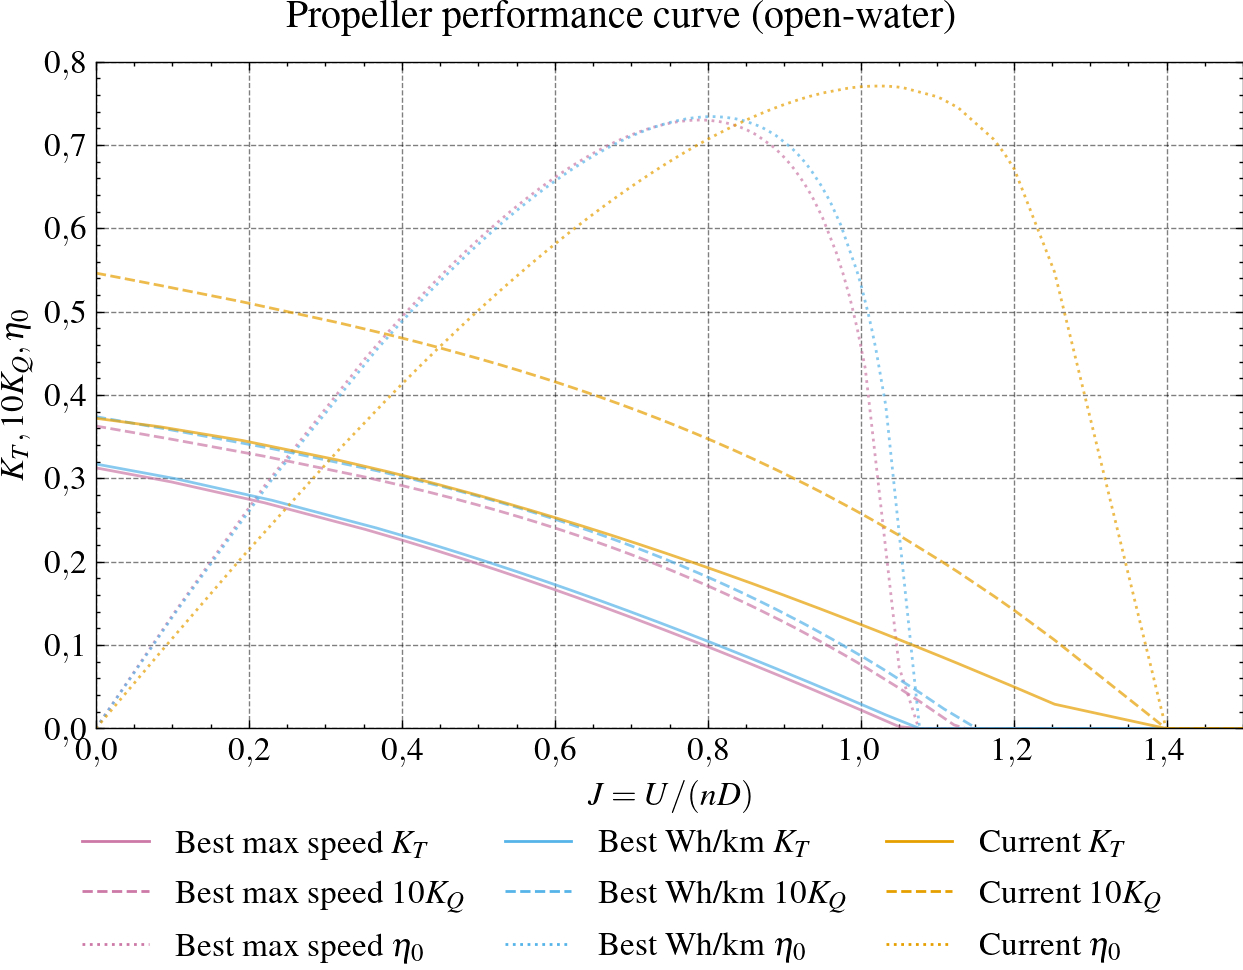

In [ ]:
def plot_prop_perf(ax, df: pd.DataFrame, color: str, prop_name: str):
    cols = ["prop_j", "prop_k_t_ow", "prop_k_q_ow", "prop_eta_ow"]

    d = df.dropna(subset=cols).sort_values("prop_j")
    d = d[(d["prop_j"] >= 0.0) & (d["prop_j"] <= 1.5)]
    ax.plot(
        d["prop_j"],
        d["prop_k_t_ow"],
        color=color,
        linestyle="-",
        label=f"{prop_name} $K_T$",
        alpha=0.7,
    )
    ax.plot(
        d["prop_j"],
        10.0 * d["prop_k_q_ow"],
        color=color,
        linestyle="--",
        label=f"{prop_name} $10K_Q$",
        alpha=0.7,
    )
    ax.plot(
        d["prop_j"],
        d["prop_eta_ow"],
        color=color,
        linestyle=":",
        label=f"{prop_name} $\eta_0$",
        alpha=0.7,
    )


fig, ax = plt.subplots()
plot_prop_perf(ax, df_speed, "C2", "Best max speed")
plot_prop_perf(ax, df_wh, "C1", "Best Wh/km")
plot_prop_perf(ax, df_current, "C0", "Current")
plt.xlabel("$J = U / (n D)$")
plt.ylabel("$K_T, 10K_Q, \eta_0$")
plt.xlim((0, 1.5))
plt.ylim((0, 0.8))
plt.grid(True)
fig_save_and_show(
    filename=f"{latex_img_path}/propeller_comparison_analysis_propeller_performance_curve.pdf",
    show_title="Propeller performance curve (open-water)",
    save_title="Curva clássica de desempenho do hélice (open-water)",
    ncol=3,
    fig=fig,
)